# STL Urban Analytics — Data Exploration

Interactive notebook for exploring the datasets powering the STL Urban Analytics dashboard.

**Datasets** (loaded from `../../public/data/`):
- `csb_latest.json` — 311 CSB complaints (latest year)
- `neighborhoods.geojson` — 79 neighborhood boundaries
- `stops.geojson` / `shapes.geojson` / `routes.json` — Metro Transit GTFS
- `food_deserts.geojson` — USDA food access tracts
- `grocery_stores.geojson` — Grocery store locations
- `trends.json` — Multi-year trends + weather data

In [1]:
import json
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

DATA_DIR = Path("../../public/data")


def load_json(name: str) -> dict:
    """Load a JSON file from the data directory."""
    with open(DATA_DIR / name) as f:
        return json.load(f)


def load_geojson(name: str) -> gpd.GeoDataFrame:
    """Load a GeoJSON file as a GeoDataFrame."""
    return gpd.read_file(DATA_DIR / name)


print("Available datasets:")
for f in sorted(DATA_DIR.iterdir()):
    size_kb = f.stat().st_size / 1024
    print(f"  {f.name:<30} {size_kb:>8.1f} KB")

Available datasets:
  csb_2024.json                    1682.0 KB
  food_deserts.geojson               13.6 KB
  grocery_stores.geojson              3.1 KB
  neighborhoods.geojson             180.3 KB
  routes.json                         7.1 KB
  shapes.geojson                    616.3 KB
  stop_stats.json                   229.5 KB
  stops.geojson                     870.7 KB
  trends.json                        22.0 KB


## 1. Neighborhoods

In [2]:
neighborhoods = load_geojson("neighborhoods.geojson")
print(f"{len(neighborhoods)} neighborhoods")
print(f"Columns: {list(neighborhoods.columns)}")
neighborhoods.head()

88 neighborhoods
Columns: ['NHD_NUM', 'NHD_NAME', 'ANGLE', 'NHD_NUMTXT', 'NHD_NUM_ST', 'geometry']


,NHD_NUM,NHD_NAME,ANGLE,NHD_NUMTXT,NHD_NUM_ST,geometry
0,43,Franz Park,0.0,43 Franz Park,None,"POLYGON ((-90.29891 38.62458, -90.29844 38.624..."
1,29,Tiffany,0.0,29 Tiffany,None,"POLYGON ((-90.23673 38.62599, -90.23858 38.620..."
2,28,Botanical Heights,0.0,28 Botanical Heights,None,"POLYGON ((-90.24214 38.62713, -90.24339 38.623..."
3,40,Kings Oak,0.0,40 Kings Oak,None,"POLYGON ((-90.26453 38.62876, -90.26457 38.628..."
4,41,Cheltenham,0.0,41 Cheltenham,None,"POLYGON ((-90.27453 38.62973, -90.27546 38.625..."


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 12))
neighborhoods.plot(ax=ax, edgecolor="white", linewidth=0.5, color="#2563eb", alpha=0.6)
ax.set_title("St. Louis Neighborhoods")
ax.set_axis_off()
plt.tight_layout()
plt.show()

## 2. 311 Complaints (CSB)

In [ ]:
csb = load_json("csb_latest.json")
print(f"Year: {csb['year']}")
print(f"Total requests: {csb['totalRequests']:,}")
print(f"Categories: {len(csb['categories'])}")
print(f"Neighborhoods: {len(csb['neighborhoods'])}")
print(f"Heatmap points: {len(csb['heatmapPoints']):,}")

In [ ]:
# Top 15 complaint categories
cats = pd.Series(csb["categories"]).sort_values(ascending=False).head(15)

fig, ax = plt.subplots(figsize=(10, 6))
cats.plot.barh(ax=ax, color="#f59e0b")
ax.set_xlabel("Count")
ax.set_title(f"Top 15 Complaint Categories ({csb['year']})")
ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# Daily complaint volume
daily = pd.Series(csb["dailyCounts"])
daily.index = pd.to_datetime(daily.index)

fig, ax = plt.subplots(figsize=(14, 4))
daily.plot(ax=ax, linewidth=0.8, color="#3b82f6")
daily.rolling(7).mean().plot(ax=ax, linewidth=2, color="#ef4444", label="7-day avg")
ax.set_title("Daily 311 Complaint Volume")
ax.set_ylabel("Complaints")
ax.legend()
plt.tight_layout()
plt.show()

## 3. Transit (GTFS)

In [9]:
stops = load_geojson("stops.geojson")
shapes = load_geojson("shapes.geojson")
routes = load_json("routes.json")
stop_stats = load_json("stop_stats.json")

print(f"Stops: {len(stops)}")
print(f"Route shapes: {len(shapes)}")
print(f"Routes: {len(routes)}")
print(f"Stops with stats: {len(stop_stats)}")

Stops: 5113
Route shapes: 62
Routes: 62
Stops with stats: 5113


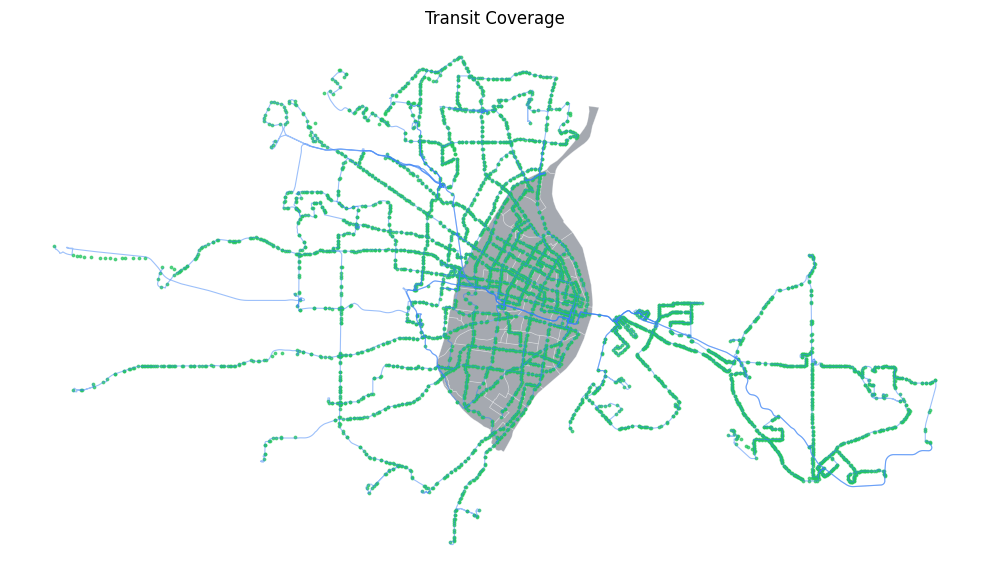

In [10]:
# Transit coverage: stops overlaid on neighborhoods
fig, ax = plt.subplots(1, 1, figsize=(10, 12))
neighborhoods.plot(ax=ax, edgecolor="white", linewidth=0.5, color="#1e293b", alpha=0.4)
shapes.plot(ax=ax, linewidth=0.8, color="#3b82f6", alpha=0.5)
stops.plot(ax=ax, markersize=3, color="#22c55e", alpha=0.7)
ax.set_title("Transit Coverage")
ax.set_axis_off()
plt.tight_layout()
plt.show()

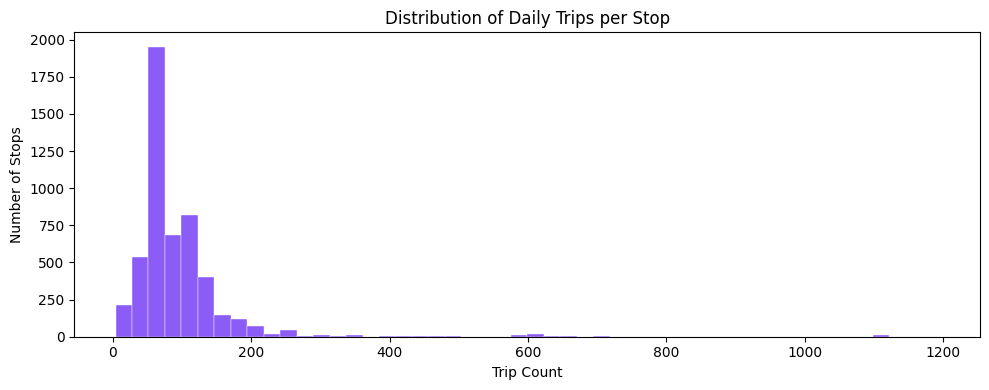

In [11]:
# Trip frequency distribution
trip_counts = [s["trip_count"] for s in stop_stats.values()]

fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(trip_counts, bins=50, color="#8b5cf6", edgecolor="white", linewidth=0.3)
ax.set_title("Distribution of Daily Trips per Stop")
ax.set_xlabel("Trip Count")
ax.set_ylabel("Number of Stops")
plt.tight_layout()
plt.show()

## 4. Food Deserts

In [12]:
food_deserts = load_geojson("food_deserts.geojson")
grocery = load_geojson("grocery_stores.geojson")

print(f"Census tracts: {len(food_deserts)}")
print(f"Grocery stores: {len(grocery)}")

lila_count = food_deserts["lila"].sum()
print(f"LILA (low income + low access) tracts: {lila_count} ({lila_count/len(food_deserts)*100:.0f}%)")

Census tracts: 25
Grocery stores: 22
LILA (low income + low access) tracts: 20 (80%)


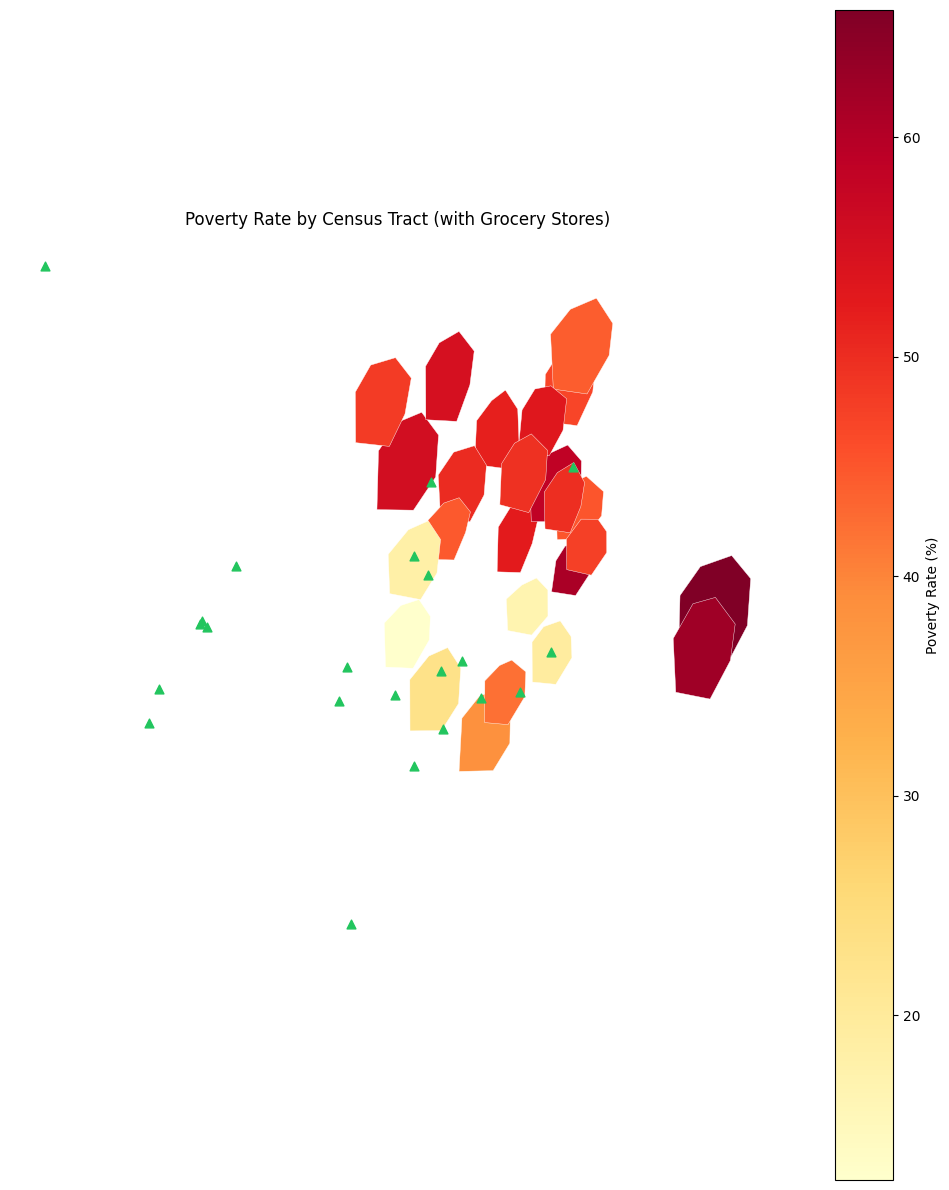

In [13]:
# Poverty rate choropleth
fig, ax = plt.subplots(1, 1, figsize=(10, 12))
food_deserts.plot(
    column="poverty_rate",
    ax=ax,
    legend=True,
    cmap="YlOrRd",
    edgecolor="white",
    linewidth=0.3,
    legend_kwds={"label": "Poverty Rate (%)"},
)
grocery.plot(ax=ax, markersize=40, color="#22c55e", marker="^", zorder=5)
ax.set_title("Poverty Rate by Census Tract (with Grocery Stores)")
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [14]:
# Summary stats
food_deserts[["pop", "poverty_rate", "pct_no_vehicle", "median_income"]].describe().round(1)

,pop,poverty_rate,pct_no_vehicle,median_income
count,25.0,25.0,25.0,25.0
mean,2432.5,44.5,35.9,26212.0
std,826.3,15.0,12.4,15070.9
min,1245.0,12.5,8.4,12400.0
25%,1834.0,42.1,31.7,17800.0
50%,2234.0,48.2,38.9,20200.0
75%,2876.0,53.1,43.1,23400.0
max,4523.0,65.8,55.2,62300.0


## 5. Weather Correlation

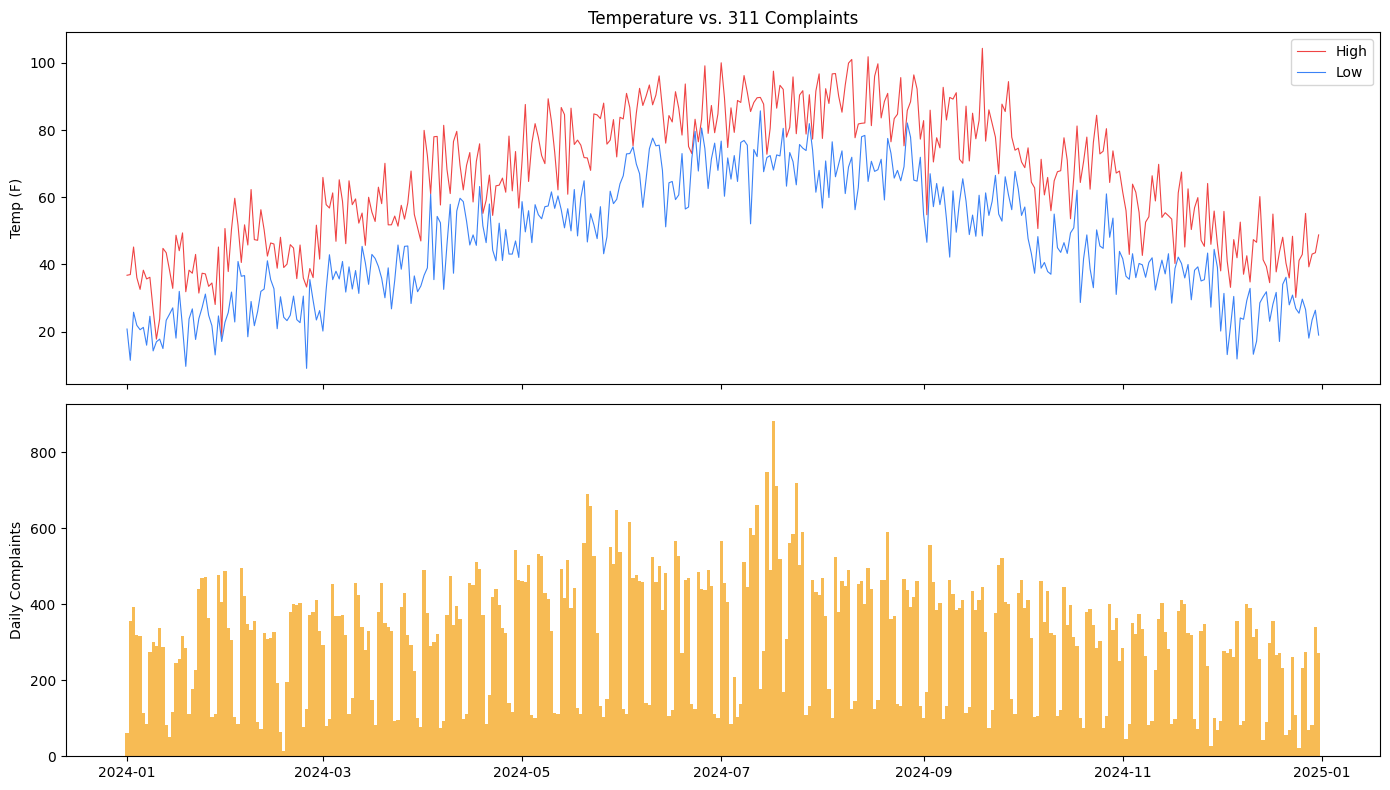


Correlation (high temp vs complaints): 0.310
Correlation (precip vs complaints):     0.010


In [15]:
trends = load_json("trends.json")
weather = trends.get("weather2024", {})

if weather:
    wx = pd.DataFrame.from_dict(weather, orient="index")
    wx.index = pd.to_datetime(wx.index)
    wx = wx.sort_index()

    # Merge with daily complaints
    daily_s = pd.Series(csb["dailyCounts"], name="complaints")
    daily_s.index = pd.to_datetime(daily_s.index)

    merged = wx.join(daily_s, how="inner")

    fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
    axes[0].plot(merged.index, merged["high"], color="#ef4444", linewidth=0.8, label="High")
    axes[0].plot(merged.index, merged["low"], color="#3b82f6", linewidth=0.8, label="Low")
    axes[0].set_ylabel("Temp (F)")
    axes[0].legend()
    axes[0].set_title("Temperature vs. 311 Complaints")

    axes[1].bar(merged.index, merged["complaints"], width=1, color="#f59e0b", alpha=0.7)
    axes[1].set_ylabel("Daily Complaints")

    plt.tight_layout()
    plt.show()

    print(f"\nCorrelation (high temp vs complaints): {merged['high'].corr(merged['complaints']):.3f}")
    print(f"Correlation (precip vs complaints):     {merged['precip'].corr(merged['complaints']):.3f}")
else:
    print("No weather data available in trends.json")

---

## Scratch Space

Use the cells below for ad-hoc exploration.